# Kaggle Goodreads - Book Ratings

## Topics & Techniques Covered
* Reading in a badly-formatted dataset
* Working with `bytes` objects and the `io` module
* Cleaning *before* loading into pandas

In [1]:
import requests
from io import BytesIO, StringIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats 

This Goodreads dataset was originally posted on Kaggle:

https://www.kaggle.com/datasets/jealousleopard/goodreadsbooks

In [2]:
#Incorrectly-formatted csv; fails to open. How do we fix it?
#df = pd.read_csv('books.csv')

books_csv_url = 'https://raw.githubusercontent.com/ClaremontCollegesLibrary/PersnicketyPython/refs/heads/main/books.csv'

df = pd.read_csv(books_csv_url)

ParserError: Error tokenizing data. C error: Expected 12 fields in line 3350, saw 13


#### What does this ParserError mean? (Click to expand)

`ParserError: Error tokenizing data. C error: Expected 12 fields in line 3350, saw 13` means that there are irregular numbers of commas on different lines the csv file, so the pandas `.read_csv()` method isn't able to parse the document correctly.

This is frustrating, but we won't know how big a problem it is without investigating further.

### Looking at the Data

Pandas's `.read_csv()` can pull directly from a csv file at a specific URL, but since it can't read the csv correctly, we have to load the file into memory another way. We can use the `requests` module to make an HTML "get" request and look at the content of the response.

In [3]:
books_csv = requests.get(books_csv_url).content

Here are the first thousand characters of the csv file, returned as a Python [Bytes object](https://docs.python.org/3/library/stdtypes.html#bytes-objects)

Bytes objects display similarly to Python strings (they are formatted like a string, with a "b" at the start before the quotes) but they are fundamentally different.

In [4]:
books_csv[0:1000]

b'bookID,title,authors,average_rating,isbn,isbn13,language_code,  num_pages,ratings_count,text_reviews_count,publication_date,publisher\n1,Harry Potter and the Half-Blood Prince (Harry Potter  #6),J.K. Rowling/Mary GrandPr\xc3\xa9,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.\n2,Harry Potter and the Order of the Phoenix (Harry Potter  #5),J.K. Rowling/Mary GrandPr\xc3\xa9,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.\n4,Harry Potter and the Chamber of Secrets (Harry Potter  #2),J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic\n5,Harry Potter and the Prisoner of Azkaban (Harry Potter  #3),J.K. Rowling/Mary GrandPr\xc3\xa9,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.\n8,Harry Potter Boxed Set  Books 1-5 (Harry Potter  #1-5),J.K. Rowling/Mary GrandPr\xc3\xa9,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic\n9,Unauthorized Harry Potter Book Sev

At first glance, it looks like it's formatted correctly, but this file is thousands of lines long. Let's see if we can identify which rows are formatted incorrectly.

First, we need to look for outliers in line length.

To read in the Bytes object as a csv file, we need to use a mechanism called a context manager. This is essentially a way of opening and closing a file all in one sequence, so that system resources aren't left occupied and may be freed up for other processes. In Python, context managers typically take the form of a "with... as" statement.

All the code within the "with" block 

In [5]:
commas = []

with BytesIO(books_csv) as f:
    lines = f.readlines()
    for line in lines:
        line = line.decode('utf-8')
        commas.append(line.count(','))

In [6]:
#Running this code outside the "with" block will produce an error.

#f.readlines()

In [7]:
set(commas)

{11, 12}

If we look back at the first line of the csv, we see the following columns:

bookID,title,authors,average_rating,isbn,isbn13,language_code,  num_pages,ratings_count,text_reviews_count,publication_date,publisher

There are twelve in total, so there should be eleven commas per line separating entries. We need to look for lines that contain more than 11 commas.

In [8]:
with BytesIO(books_csv) as f:
    lines = f.readlines()
    for line in lines:
        line = line.decode('utf-8')
        
        if line.count(',') > 11:
            print(line)

12224,Streetcar Suburbs: The Process of Growth in Boston  1870-1900,Sam Bass Warner, Jr./Sam B. Warner,3.58,0674842111,9780674842113,en-US,236,61,6,4/20/2004,Harvard University Press

16914,The Tolkien Fan's Medieval Reader,David E. Smith (Turgon of TheOneRing.net, one of the founding members of this Tolkien website)/Verlyn Flieger/Turgon (=David E. Smith),3.58,1593600119,9781593600112,eng,400,26,4,4/6/2004,Cold Spring Press

22128,Patriots (The Coming Collapse),James Wesley, Rawles,3.63,156384155X,9781563841552,eng,342,38,4,1/15/1999,Huntington House Publishers

34889,Brown's Star Atlas: Showing All The Bright Stars With Full Instructions How To Find And Use Them For Navigational Purposes And Department Of Trade Examinations.,Brown, Son & Ferguson,0.00,0851742718,9780851742717,eng,49,0,0,5/1/1977,Brown Son & Ferguson Ltd.



Only four lines! That's manageable!

We can use the `.replace()` string method to fix this pretty quickly. We just need to provide enough context around the comma so we don't accidentally replace text in other parts of the document.

In [9]:
with BytesIO(books_csv) as f:
    content = f.read()
    content = content.decode('utf-8')
    content = content.replace(', Jr', ' Jr')
    content = content.replace(', one of the', ' one of the')
    content = content.replace('Wesley, Rawles', 'Wesley Rawles')
    content = content.replace(', Son & Ferguson', ' Son & Ferguson')
    df = pd.read_csv(StringIO(content), sep=',')

*Note: if you are running this locally and pointing to a csv file on your hard drive instead of the result of an HTML "get" request, you should use the following code instead:*

In [10]:
#with open("books.csv", 'r', encoding='utf-8') as f:
#    content = f.read()
#    content = content.replace(', Jr', ' Jr')
#    content = content.replace(', one of the', ' one of the')
#    content = content.replace('Wesley, Rawles', 'Wesley Rawles')
#    content = content.replace(', Son & Ferguson', ' Son & Ferguson')
#    df = pd.read_csv(StringIO(content), sep=',')

In [11]:
df

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic
...,...,...,...,...,...,...,...,...,...,...,...,...
11122,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,12/21/2004,Da Capo Press
11123,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,12/1/1988,Penguin Books
11124,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,8/1/1993,Penguin Books
11125,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,2/27/2007,Ecco


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11127 entries, 0 to 11126
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11127 non-null  int64  
 1   title               11127 non-null  object 
 2   authors             11127 non-null  object 
 3   average_rating      11127 non-null  float64
 4   isbn                11127 non-null  object 
 5   isbn13              11127 non-null  int64  
 6   language_code       11127 non-null  object 
 7     num_pages         11127 non-null  int64  
 8   ratings_count       11127 non-null  int64  
 9   text_reviews_count  11127 non-null  int64  
 10  publication_date    11127 non-null  object 
 11  publisher           11127 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB


### "  num_pages"

In [13]:
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

In [14]:
df.columns = [column.strip() for column in df.columns]

In [15]:
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

In [16]:
df.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11127.000000,11127.000000,1.112700e+04,11127.000000,1.112700e+04,11127.000000
mean,21310.938887,3.933631,9.759888e+12,336.376921,1.793641e+04,541.854498
std,13093.358023,0.352445,4.428964e+11,241.127305,1.124794e+05,2576.176608
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10287.000000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780586e+12,299.000000,7.450000e+02,46.000000
75%,32104.500000,4.135000,9.780873e+12,416.000000,4.993500e+03,237.500000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


In [17]:
df['language_code'].value_counts()

language_code
eng      8911
en-US    1409
spa       218
en-GB     214
fre       144
ger        99
jpn        46
mul        19
zho        14
grc        11
por        10
en-CA       7
ita         5
enm         3
lat         3
swe         2
rus         2
srp         1
nl          1
msa         1
glg         1
wel         1
ara         1
nor         1
tur         1
gla         1
ale         1
Name: count, dtype: int64

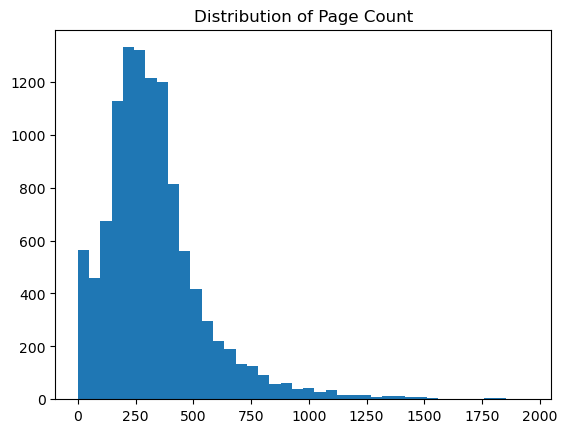

In [18]:
plt.hist(df[df['num_pages'] < 2000]['num_pages'], bins=40)
plt.title('Distribution of Page Count')
plt.show()

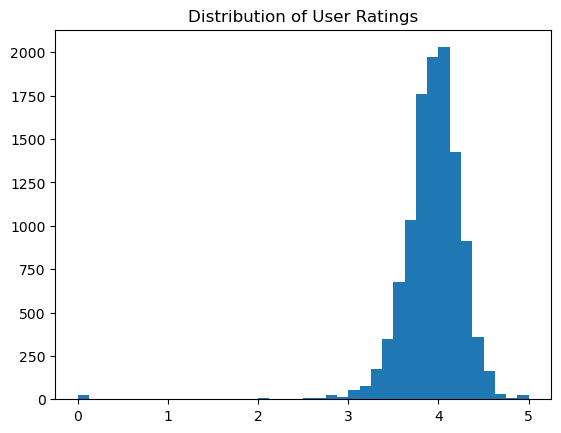

In [19]:
plt.hist(df['average_rating'], bins=40)
plt.title('Distribution of User Ratings')
plt.show()

# Books with Mean Rating over 4.75 and 5+ Ratings

In [20]:
df[(df['average_rating'] > 4.75) & (df['ratings_count'] > 5)]


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic
4374,15705,Existential Meditation,Simon Cleveland,4.91,1411665309,9781411665309,eng,100,11,3,12/22/2005,Lulu.com
4813,17277,The Feynman Lectures on Physics Vols 7-8,Richard P. Feynman,4.80,0738209279,9780738209272,en-US,0,20,0,1/3/2006,Basic Books
6590,24812,The Complete Calvin and Hobbes,Bill Watterson,4.82,0740748475,9780740748479,eng,1456,32213,930,9/6/2005,Andrews McMeel Publishing
6592,24814,It's a Magical World (Calvin and Hobbes #11),Bill Watterson,4.76,0836221362,9780836221367,eng,176,23875,303,9/1/1996,Andrews McMeel Publishing
9434,37424,Little Big Book for God's Children,Alice Wong/Lena Tabori,4.88,094180755X,9780941807555,en-US,352,8,0,9/1/2001,Welcome Books
9816,39382,Corvette,Jerry Burton,4.83,0883631210,9780883631218,eng,320,6,1,10/1/2006,Universe Publishing(NY)


# End of Module 3